In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import qutip as qt
#from scipy import ndimage, misc
#from ifigures import *
#from ifigures.my_plots import *
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.linalg import kron, eig
import time

In [2]:
import matplotlib.colors as mcolors
import colorsys


#: Durham colour scheme
cDUp = "#7E317B"  # Palatinate Purple
cDUpp =  "#D8ACF4"  # Light purple

cDUb = "#006388"  # Blue
cDUbb = "#91B8BD"  # Mid Blue
cDUbbb = "#C4E5FA"  # Light Blue
cDUbbbb = "#00AEEF"

cDUsky = "#A5C8D0"  # sky blue

cDUo = "#9FA161"  # Olive Green

cDUr = "#AA2B4A"  # Red
cDUrr = "#BE1E2D"
cDUy = "#E8E391" #  Yellow

cDUp = "#C43B8E" # Pink

cDUk = "#231F20"  # Black
cDUkk = "#002A41" # ink

cDUggg = "#CFDAD1"  # Near White/L. Grey
cDUgg = "#968E85"  # Warm Grey
cDUg = "#6E6464"  # midgrey

In [3]:
def make_colormap(seq):
    """
        Args:
            seq: a sequence of floats and RGB-tuples. The floats should be
                increasing and in the interval (0,1).

        Returns:
            a LinearSegmentedColormap
    """
    seq = [(None, ) * 3, 0.0] + list(seq) + [1.0, (None, ) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
rvb = make_colormap([
    c('#b20000'),
    c('#fe7600'), 0.125,
    c('#fe7600'),
    c('#feca00'), 0.25,
    c('#feca00'),
    c('#bcfd00'), 0.375,
    c('#bcfd00'),
    c('#06a133'), 0.5,
    c('#06a133'),
    c('#00f6fd'), 0.625,
    c('#00f6fd'),
    c('#000cfe'), 0.75,
    c('#000cfe'),
    c('#e404fe'), 0.875,
    c('#e404fe'),
    c('#b20000')
])


def getColor(amplitude, phase, maxAmplitude):
    c = rvb(phase / (2. * np.pi))
    scale = amplitude / maxAmplitude
    if scale > 1:
        raise ValueError(
            'Amplitude of the passed complex number is bigger than the'
            ' maximal set amplitudeyter not')
    cc = colorsys.rgb_to_hls(c[0], c[1], c[2])
    c = colorsys.hls_to_rgb(cc[0], cc[1] + (1. - scale) * (1. - cc[1]), cc[2])
    return (c[0], c[1], c[2], 1.0)


def getComplexColor(complexNo, maxAmplitude):
    """
    Get color for a complex numbers

    Represents phase as continous colour wheel, and amplitude as intensity
    of color (zero amplitude = white color), with linear mapping in between.

    Args:
        complexNo (complex float): complex number
        maxAmplitude (float): maximum amplitude in the data set we want to
            represent as colour mapped dots. This is used for normalizing color
            intensity, going from maximal saturation or `maxAmplitude` to
            white color for zero amplitude.

    Returns:
        color as [red, green, blue, alpha]
    """
    angle = np.angle(complexNo)
    if angle < 0:
        angle += 2 * np.pi
    return getColor(np.absolute(complexNo), angle, maxAmplitude)

def white_to_transparency(img):
    """
        Converts white areas of image to transprancy.
    """
    x = np.asarray(img.convert('RGBA')).copy()

    x[:, :, 3] = (255 * (x[:, :, :3] != 255).any(axis=2)).astype(np.uint8)

    return Image.fromarray(x)


In [88]:
def EIT(Omega,Delta,tmax,npts):
    rho0=np.mat([[1.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    t=np.linspace(0,tmax,npts)
    rho = (1.0+1.0j)*np.zeros((9,npts))    
    I3=np.eye(3,3)
    OmegaP=1.0
    OmegaC=2.0
    GammaB=1.0
    GammaC=0.001
    DP=Delta
    DC=0.0
    
    L=np.zeros((9,9))
    L[0,4]=GammaB #rho_aa
    L[4,4]=-GammaB #rho_bb 
    L[1,1]=-GammaB/2 #rho_ab
    L[2,2]=-GammaC/2 #rho_ac
    L[3,3]=-GammaB/2 #rho_ba
    L[4,8]=GammaC #rho_bb
    L[8,8]=-GammaC #rho_cc
    L[5,5]=-(GammaB+GammaC)/2 #rho_bc
    L[6,6]=-GammaC/2 #rho_ca
    L[7,7]=-(GammaB+GammaC)/2 #rho_cb

    
    H=0.5*np.array([[0, OmegaP, 0],[OmegaP, -2*DP, OmegaC], [0, OmegaC, -2*(DP-DC)]])
    Hrho=kron(H,I3)
    rhoH=kron(I3,np.conj(H))
    evals, evecs = eig(-1.j*(Hrho-rhoH)+L)


    evecs=np.mat(evecs)
    for i in range(0,npts):
        rho_vec=evecs*np.mat(np.diag(np.exp(evals*t[i])))*np.linalg.inv(evecs)*rho0 # .dot not needed here
        rho[:,i] = np.squeeze(np.asarray(rho_vec))
    return rho



161 85


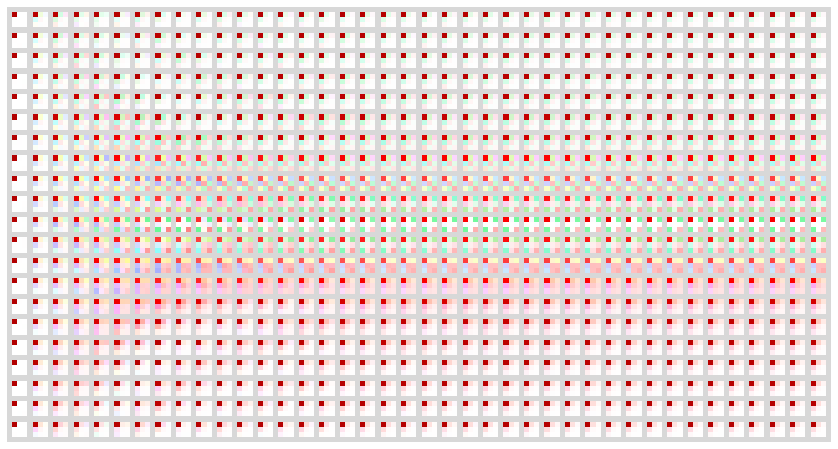

3.027255058288574


<Figure size 432x288 with 0 Axes>

In [91]:
start = time.time()
npts=800
tmax=2.0*np.pi*5
t=np.linspace(0,tmax,npts)
mdim = 3 # matrix dimension
time_dim = 40 # no. of times to plot across rows

#time_dim = 40 # no. of times to plot across rows

parameter_dim = 21 # no. of parameter values down columns

h_dim = time_dim*(mdim+1)+1
v_dim = parameter_dim*(mdim+1)+1

print (h_dim,v_dim)

R=0.85*np.ones((v_dim,h_dim))
G=0.85*np.ones((v_dim,h_dim))
B=0.85*np.ones((v_dim,h_dim))

fig, ax=plt.subplots(figsize=(16, 8))

Dmax=5.0

Deltas=np.linspace(-Dmax,Dmax,parameter_dim)


for v_index in range(0, parameter_dim): # v_index is no. of rows    
    Delta = Deltas[v_index]
    Omega = 5.0+0.000001
    rho = EIT(Omega,Delta,tmax,npts)
    peak = np.amax(abs(rho))
    for h_index in range(0, time_dim): # h_index is no. of columns
        t_index=10*h_index        
        for col in range (0,mdim):
            for row in range (0,mdim):
#                print ((mdim+1)*v_index+1+row,(mdim+1)*h_index+1+col,col+3*row)
                R[(mdim+1)*v_index+1+row,(mdim+1)*h_index+1+col]=getComplexColor(rho[col+3*row,t_index],peak)[0]
                G[(mdim+1)*v_index+1+row,(mdim+1)*h_index+1+col]=getComplexColor(rho[col+3*row,t_index],peak)[1]
                B[(mdim+1)*v_index+1+row,(mdim+1)*h_index+1+col]=getComplexColor(rho[col+3*row,t_index],peak)[2]

RGB=np.dstack((R, G, B))
    
plt.imshow(RGB)
ax.set_axis_off() 
plt.show()

plt.savefig("EIT_vs_detuing.png", dpi=600)


end = time.time()
print(end - start)